In [121]:
import scipy.io
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Loading data
np.set_printoptions(suppress=True)
data = scipy.io.loadmat('data.mat')
data2 = scipy.io.loadmat('data2.mat')
X_train = data['X']
Y_val = data['yval']
X_val = data['Xval']

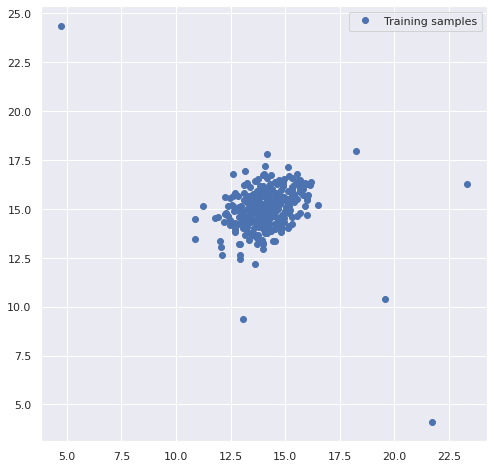

In [122]:
sns.set()
plt.figure(figsize=(8,8))
plt.plot(X_train[:, 0], X_train[:, 1], 'bo', label='Training samples')
plt.legend()

In [125]:
# Only one vector
def estimate_Gaussian(X):
    mu = np.sum(X) / X.shape[0]
    sigma2 = np.sum((X - mu)**2) / X.shape[0]
    return mu, sigma2

def gaussian_distribution(x, mu, sigma2):
    nom = np.exp(-(x - mu)**2 / 2*sigma2)
    dom = np.sqrt(2 * np.pi * sigma2)
    return nom / dom

# For higher dimensions
def MEG(X):
    mu = np.sum(X, axis=0) / (X.shape[0]-1)
    sigma = (X - mu).T @ (X - mu) / (X.shape[0]-1)
    return mu, sigma

def MGD(X, mu, sigma):
    x_mu = X - mu
    nom = np.exp(-0.5 * x_mu @ np.linalg.pinv(sigma) * x_mu)
    dom = (2*np.pi)**(X.shape[1] / 2) * np.linalg.det(sigma)**0.5
    return nom / dom

# Finding best threshold to predict anomalies
def select_epsilon(Y_train, dist):
    best_score = 0
    best_epsilon = np.min(dist)
    step = (np.max(dist) - np.min(dist)) / 1000;
    eps = np.min(dist)
    prod = np.prod(dist, axis=1).reshape((dist.shape[0], 1))
    while eps < np.max(dist):
        pred = prod < eps
        tp = np.sum(np.logical_and(pred == True, Y_train == 1))
        tn = np.sum(np.logical_and(pred == False, Y_train == 0))
        fp = np.sum(np.logical_and(pred == True, Y_train == 0))
        fn = np.sum(np.logical_and(pred == False, Y_train == 1))
        precision = tp/(tp + fp)
        recall = tp/(tp + fn)
        score = 2*precision*recall / (precision + recall)
        if score > best_score:
            best_score = score
            best_epsilon = eps
        eps += step
    return best_epsilon
        
mu, sig = MEG(X_val)
p = MGD(X_val, mu, sig)
print(p.shape)
eps = select_epsilon(Y_val, p)
mu, sig = MEG(X_train)
p = MGD(X_train, mu, sig)

(307, 2)


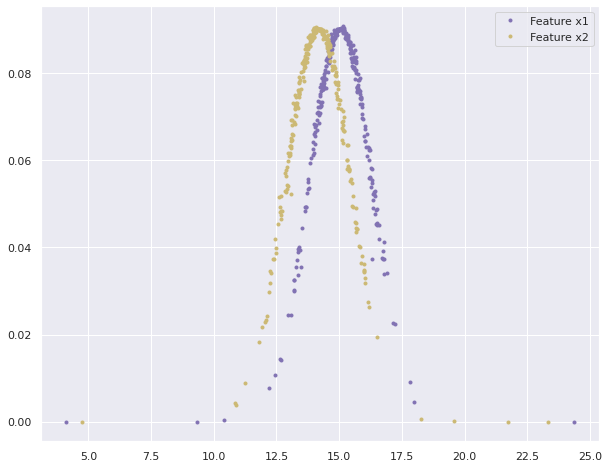

In [126]:
plt.figure(figsize=(10,8))
plt.plot(X_train[:, 1] ,p[:, 1], 'm.', label='Feature x1')
plt.plot(X_train[:, 0] ,p[:, 0], 'y.', label='Feature x2')
plt.legend()

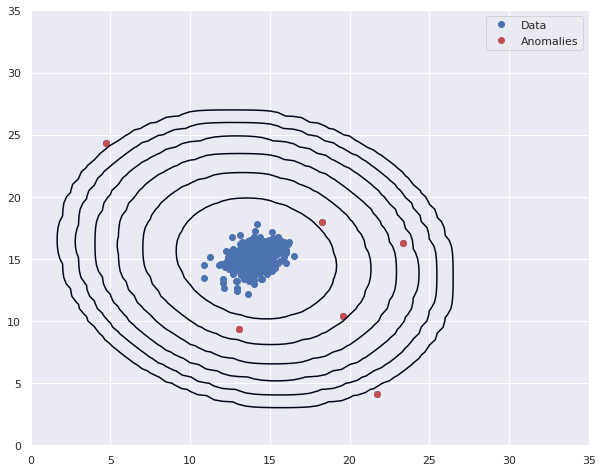

In [127]:
# Anomalies for given epsilon
anomalies = X_train[p[:, 0] * p[:, 1] < eps]

X1, X2 = np.meshgrid(np.arange(0, 35.5, 0.5), np.arange(0, 35.5, 0.5))
stacked = np.stack([X1.ravel(), X2.ravel()], axis=1)
Z = MGD(stacked, mu, sig)
Z = Z[:, 0] * Z[:, 1]
Z = Z.reshape(X1.shape)

plt.figure(figsize=(10,8))
plt.plot(X_train[:, 0], X_train[:, 1], 'bo', label='Data')
plt.plot(anomalies[:, 0], anomalies[:, 1], 'ro', label='Anomalies')
plt.contour(X1, X2, Z, levels=10**(np.arange(-20., 1, 3)), zorder=100)
plt.legend()


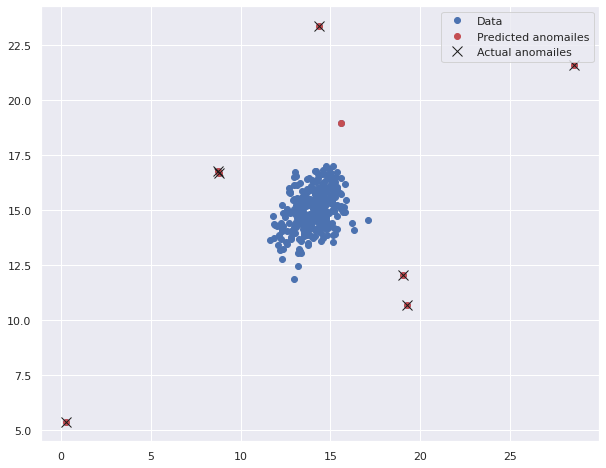

In [129]:
# Predictions on validation set
p = MGD(X_val, mu, sig)
pred = X_val[p[:, 0] * p[:, 1] < eps]
anomalies_x1 = X_val[:, 0][:, np.newaxis][Y_val == 1]
anomalies_x2 = X_val[:, 1][:, np.newaxis][Y_val == 1]

plt.figure(figsize=(10,8))
plt.plot(X_val[:, 0], X_val[:, 1], 'bo', label='Data')
plt.plot(pred[:, 0], pred[:, 1], 'ro', label='Predicted anomailes')
plt.plot(anomalies_x1[2:], anomalies_x2[2:], 'kx',markersize=10, label='Actual anomailes')
plt.legend()


In [138]:
##### More feautres...

X_train = data2['X']
Y_val = data2['yval']
X_val = data2['Xval']

In [139]:
mu, sig = MEG(X_val)
p = MGD(X_val, mu, sig)
eps = select_epsilon(Y_val, p)
mu, sig = MEG(X_train)
p = MGD(X_train, mu, sig)

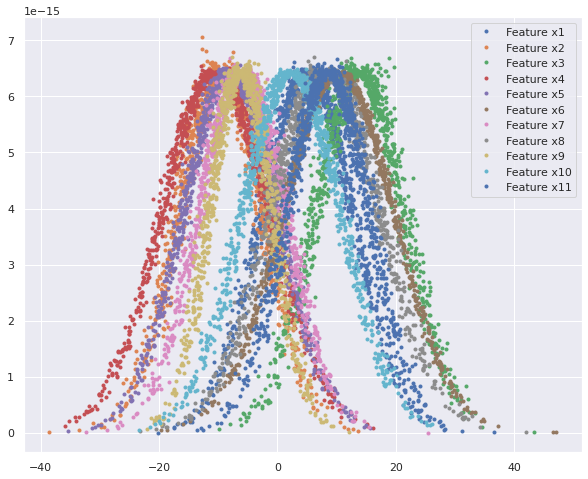

In [140]:
plt.figure(figsize=(10,8))
for i in range(X_train.shape[1]):
    plt.plot(X_train[:, i] ,p[:, i], '.', label=f'Feature x{i+1}')
plt.legend()